# Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

In [1]:
# LINK: (https://keras.io/examples/vision/image_classification_from_scratch/)

# Setup.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Load the data: the Cats vs Dogs dataset.(download)
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  41.8M      0  0:00:18  0:00:18 --:--:-- 38.7M


In [3]:
# Unzip dataset.
!unzip -q kagglecatsanddogs_3367a.zip
!ls

MSR-LA - 3467.docx          kagglecatsanddogs_3367a.zip
PetImages                   readme[1].txt
catsvsdogs.ipynb


In [4]:
# Each subfolder contains image files for each category.
!ls PetImages

Cat Dog


In [5]:
# Filter out corrupted images.
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


Arguments

- directory: Directory where the data is located. If labels is "inferred", it should contain subdirectories, each containing images for a class. Otherwise, the directory structure is ignored.
- labels: Either "inferred" (labels are generated from the directory structure), None (no labels), or a list/tuple of integer labels of the same size as the number of image files found in the directory. Labels should be sorted according to the alphanumeric order of the image file paths (obtained via os.walk(directory) in Python).
- label_mode: - 'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss). - 'categorical' means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss). - 'binary' means that the labels (there can be only 2) are encoded as float32 scalars with values 0 or 1 (e.g. for binary_crossentropy). - None (no labels).
- class_names: Only valid if "labels" is "inferred". This is the explict list of class names (must match names of subdirectories). Used to control the order of the classes (otherwise alphanumerical order is used).
- color_mode: One of "grayscale", "rgb", "rgba". Default: "rgb". Whether the images will be converted to have 1, 3, or 4 channels.
- batch_size: Size of the batches of data. Default: 32.
- image_size: Size to resize images to after they are read from disk. Defaults to (256, 256). Since the pipeline processes batches of images that must all have the same size, this must be provided.
- shuffle: Whether to shuffle the data. Default: True. If set to False, sorts the data in alphanumeric order.
- seed: Optional random seed for shuffling and transformations.
- validation_split: Optional float between 0 and 1, fraction of data to reserve for validation.
- subset: One of "training" or "validation". Only used if validation_split is set.
- interpolation: String, the interpolation method used when resizing images. Defaults to bilinear. Supports bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, mitchellcubic.
- follow_links: Whether to visits subdirectories pointed to by symlinks. Defaults to False.
- crop_to_aspect_ratio: If True, resize the images without aspect ratio distortion. When the original aspect ratio differs from the target aspect ratio, the output image will be cropped so as to return the largest possible window in the image (of size image_size) that matches the target aspect ratio. By default (crop_to_aspect_ratio=False), aspect ratio may not be preserved.
- **kwargs: Legacy keyword arguments.


In [6]:
# Generate a dataset.
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.


2021-08-13 00:33:39.716251: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


2021-08-13 00:33:43.268603: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


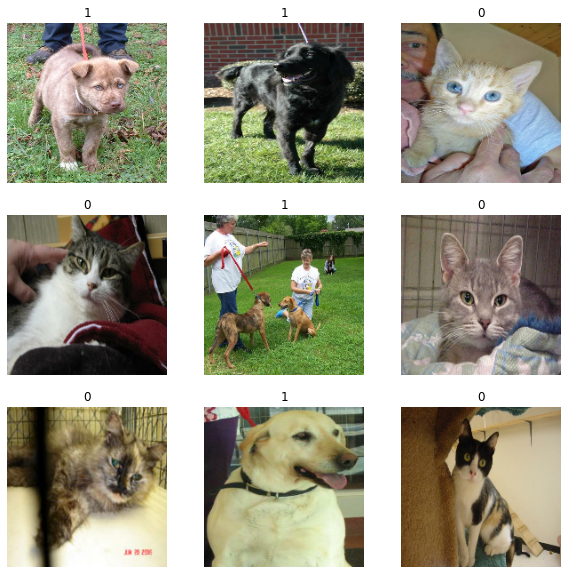

In [7]:
# Visualize the data. (training images)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
# Using image data augmentation.
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


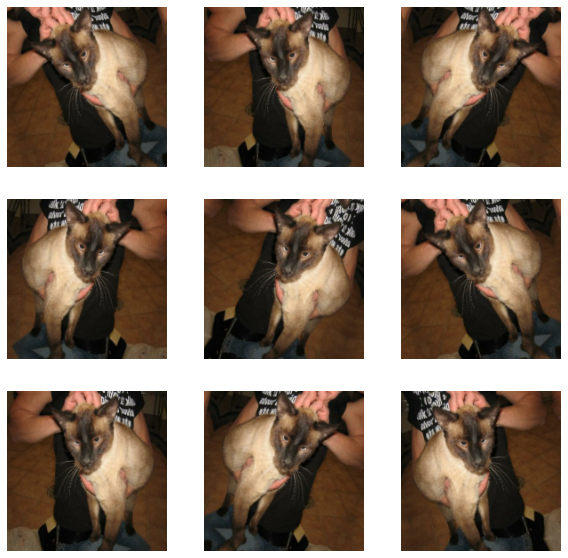

In [9]:
# Visualize the augmented images.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Standardizing the data.
Two options to preprocess the data.

In [10]:
# Option 1: Make it part of the model, like this:
"""
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model
"""

'\ninputs = keras.Input(shape=input_shape)\nx = data_augmentation(inputs)\nx = layers.experimental.preprocessing.Rescaling(1./255)(x)\n...  # Rest of the model\n'

With this option, your data augmentation will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be augmented during fit(), not when calling evaluate() or predict().

If you're training on GPU, this is the better option.

In [11]:
# Option 2: apply it to the dataset:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.

In our case, we'll go with the first option.

In [12]:
# Configure the dataset for performance.
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Build a model.

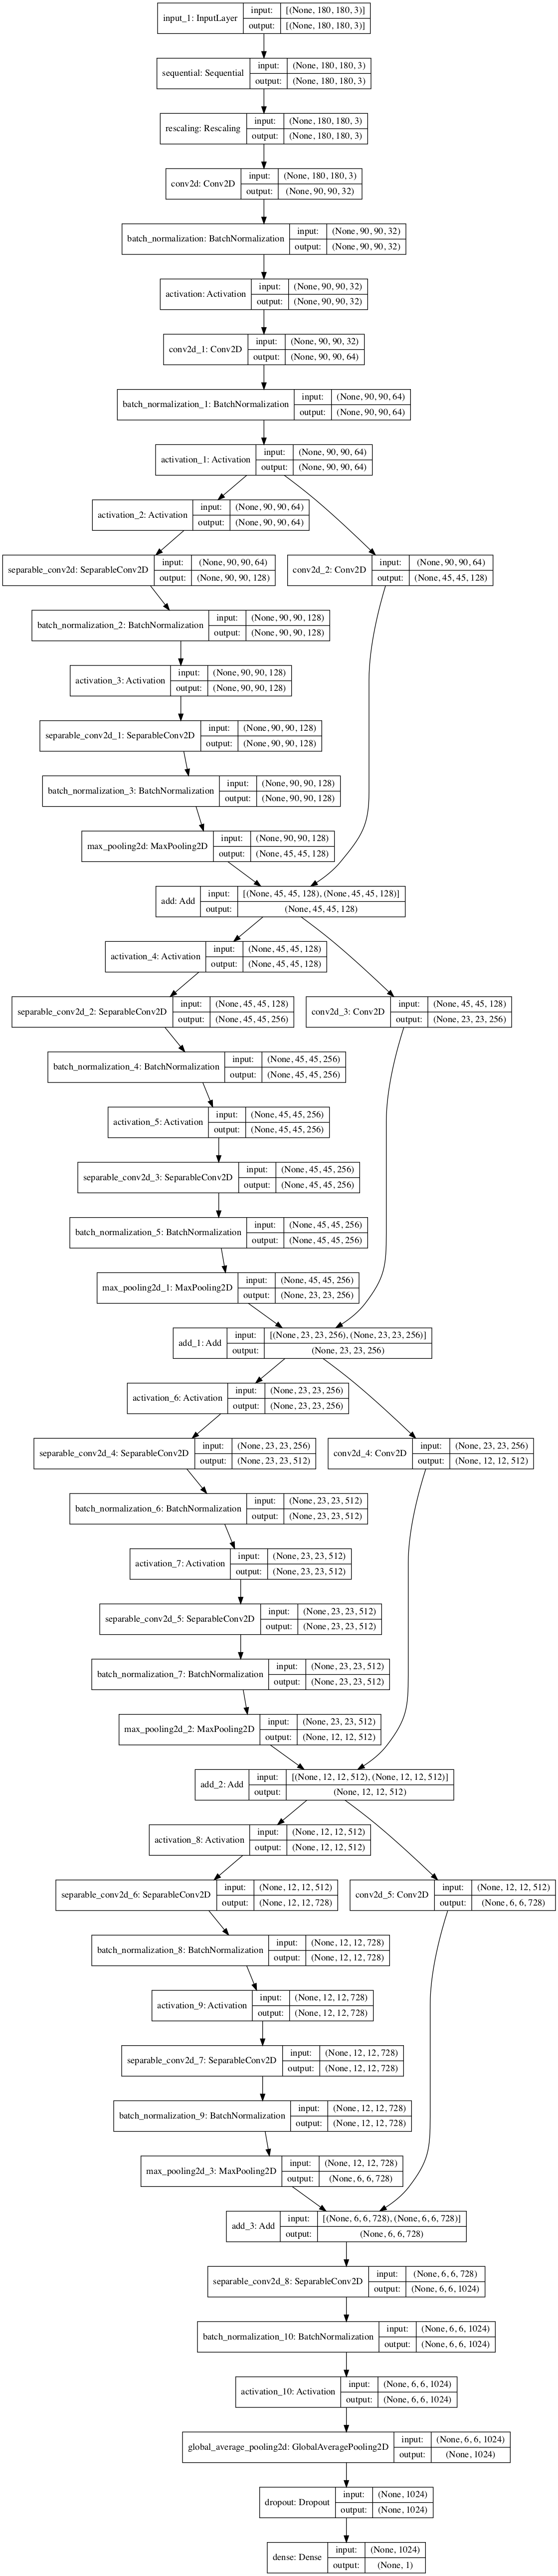

In [13]:
# We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
# We include a Dropout layer before the final classification layer.
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [14]:
# Train the model
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 31:22 - loss: 0.6827 - accuracy: 0.6112

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 27:44 - loss: 0.6700 - accuracy: 0.6222

402/586 [===================>..........] - ETA: 19:15 - loss: 0.6487 - accuracy: 0.6405

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 18:16 - loss: 0.6455 - accuracy: 0.6432

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 16:59 - loss: 0.6421 - accuracy: 0.6461

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 16:14 - loss: 0.6404 - accuracy: 0.6475

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.6109 - accuracy: 0.6711

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 3834s 7s/step - loss: 0.6109 - accuracy: 0.6711 - val_loss: 0.6546 - val_accuracy: 0.6104


/Users/atrysrocuant/Documents/personal/git/djangotflite/requirements/djangotflite/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 12/586 [..............................] - ETA: 52:14 - loss: 0.4786 - accuracy: 0.7786

KeyboardInterrupt: 

In [15]:
# Run inference on new data.
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 75.54 percent cat and 24.46 percent dog.


In [17]:
# Save the model. (HDF5JSON)
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.hdf5")

In [18]:
# Get TFLite from a simple model. (https://www.tensorflow.org/lite/convert)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model. (TFLite)
model_path = 'catsvsdogs.tflite'
with open(model_path, 'wb') as f:
  f.write(tflite_model)

2021-08-13 01:44:20.132214: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/1v/gx3qc3cn3rgbn3yrq2_l_xq40000gn/T/tmpc6zefh7i/assets


/Users/atrysrocuant/Documents/personal/git/djangotflite/requirements/djangotflite/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
2021-08-13 01:44:27.212784: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-08-13 01:44:27.213355: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-08-13 01:44:27.235573: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.009ms.
  function_optimizer: function_optimizer did nothing. time = 0.007ms.

2021-08-13 01: